<a href="https://colab.research.google.com/github/dchung117/self-driving-cars-cv/blob/main/fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Package installations

In [1]:
!pip install -q kaggle

# Imports

In [2]:
from typing import Optional
import pandas as pd
import numpy as np
import os
import random
import datetime
from base64 import b64encode
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam

import torchvision
import torchvision.transforms.functional as TF
from torchvision.models import vgg16
from torch.utils.data import random_split, Dataset

import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import clear_output, HTML

# mount google colab drive
from google.colab import files

# Download KITTI dataset

In [3]:
# Upload kaggle json
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download KITTI road segmentation data
!kaggle datasets download -d sakshaymahna/kittiroadsegmentation
!unzip -q kittiroadsegmentation.zip

100% 305M/305M [00:22<00:00, 13.9MB/s]
100% 305M/305M [00:22<00:00, 14.2MB/s]


In [5]:
# Create validation split
RANDOM_STATE = 27

train_data_dir = Path("training")
test_data_dir = Path("testing")

val_split = 0.1
test_split = 0.1

# shuffle train data
train_data_dir_list = list((train_data_dir / "image_2").iterdir())
n = len(train_data_dir_list)
random.Random(RANDOM_STATE).shuffle(train_data_dir_list)

test_data_files = train_data_dir_list[:int(test_split*n)]
val_data_files = train_data_dir_list[int(test_split*n):int(test_split*n)+int(val_split*n)]
train_data_files = train_data_dir_list[int(test_split*n)+int(val_split*n):]

# Constants

In [6]:
IMG_SIZE = 128
N_CHANNELS = 3
N_CLASSES = 1
BATCH_SIZE = 16

# Datasets

In [7]:
class KITTIDataset(Dataset):
  def __init__(self, data_files: list):
    self.data_files = data_files

  def __len__(self):
    return len(self.data_files)

  def __getitem__(self, idx: int):
    # Get image file
    file = str(self.data_files[idx])
  
    # Read img
    img = torchvision.io.read_image(file)

    # Read mask
    mask_file = file.replace("image_2", "gt_image_2")
    mask_file = mask_file.replace("um_", "um_road_")
    mask_file = mask_file.replace("umm_", "umm_road_")
    mask_file = mask_file.replace("uu_", "uu_road_")
    mask = torchvision.io.read_image(mask_file)

    # labels for non-road, road, other
    # non_road_label = torch.tensor([255, 0, 0], dtype=torch.uint8).unsqueeze(-1).unsqueeze(-1)
    road_label = torch.tensor([255, 0, 255], dtype=torch.uint8).unsqueeze(-1).unsqueeze(-1)
    # other_label = torch.tensor([0, 0, 0], dtype=torch.uint8).unsqueeze(-1).unsqueeze(-1)

    # Convert to binary mask
    mask = torch.all((mask == road_label), dim=0).unsqueeze(dim=0).to(torch.uint8)

    return img, mask

In [8]:
# Create datasets
train_dataset = KITTIDataset(train_data_files)
val_dataset = KITTIDataset(val_data_files)
test_dataset = KITTIDataset(test_data_files)

# Image Augmentations

In [9]:
def normalize(image: torch.Tensor, mask: torch.Tensor) -> tuple:
  # cast image as float, normalize
  image = image.to(torch.float32) / 255.0
  return image, mask

# train collate function
def train_collator(batch: list) -> tuple:
  def collate_fn(image: torch.Tensor, mask: torch.Tensor) -> tuple:
    # resize tensors
    image = TF.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = TF.resize(mask, (IMG_SIZE, IMG_SIZE))

    # horizontal flip w/ 0.5 prob
    if np.random.uniform() < 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)
    
    # normalize image, mask
    image, mask = normalize(image, mask)

    return image, mask

  # Apply collate function to each element in batch
  batch = [collate_fn(*x) for x in batch]

  # Unpack batch
  images, masks = zip(*batch)
  images = torch.stack(images, dim=0)
  masks = torch.stack(masks, dim=0)

  return images, masks

def test_collator(batch: list) -> tuple:
  def collate_fn(image: torch.Tensor, mask: torch.Tensor) -> tuple:
    # resize tensors
    image = TF.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = TF.resize(mask, (IMG_SIZE, IMG_SIZE))

    # normalize
    image, mask = normalize(image, mask)

    return image, mask
  
  # resize and normalize
  batch = [collate_fn(*x) for x in batch]

  # unpack batch
  images, masks = zip(*batch)
  images = torch.stack(images, dim=0)
  masks = torch.stack(masks, dim=0)

  return images, masks

# Dataloaders

In [10]:
train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=train_collator, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                    collate_fn=test_collator, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                     collate_fn=test_collator, pin_memory=True)

# Function to view image

In [62]:
def display_image(image: torch.Tensor, mask: torch.Tensor, predicted_mask: Optional[torch.Tensor] = None,
                  image_title: str = "Image", mask_title: str = "True Mask") -> None:
  plt.figure(figsize=(18,18))

  # plot image
  plt.subplot(1, 3, 1)
  plt.title(image_title)
  plt.imshow(TF.to_pil_image(image))
  plt.axis("off")

  # plot mask
  plt.subplot(1, 3, 2)
  plt.title(mask_title)
  plt.imshow(TF.to_pil_image(mask))
  plt.axis("off")

  # predicted mask (if given)
  if predicted_mask != None:
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(TF.to_pil_image(predicted_mask))
    plt.axis("off")

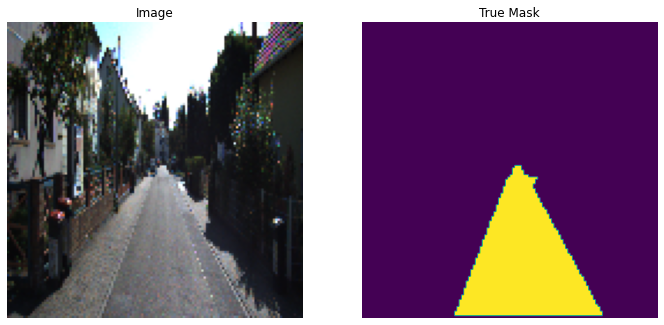

In [12]:
# test plotting function
batch_images, batch_masks = next(iter(train_dl))
display_image(image=batch_images[0], mask=batch_masks[0])

# VGG Model

In [35]:
# Download VGG16 model w/ imagenet weights
vgg16_model = vgg16(weights="IMAGENET1K_V1")

In [36]:
class VGG16FCN(nn.Module):
  def __init__(self, vgg16_body: nn.Module) -> None:
    super(VGG16FCN, self).__init__()

    # Extract blocks from vgg16_model
    block_end_idxs = ["4", "9", "16", "23", "30"]
    blocks = []
    curr_block = nn.Sequential()

    for name, module in vgg16_body.named_modules():
      # skip first module
      if len(name) > 0:
        # Append module to curr_block
        curr_block.append(module)

        # Start new block if max pool layer reached
        if name == block_end_idxs[0]:
          blocks.append(curr_block)
          block_end_idxs.pop(0)
          curr_block = nn.Sequential()
    
    self.block_1, self.block_2, self.block_3, \
      self.block_4, self.block_5 = blocks

    # Classifier head
    self.conv2d = nn.Conv2d(1280, N_CLASSES, (1, 1))
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    # Pass through first two blocks
    x = self.block_1(x)
    x = self.block_2(x)

    # Store encoded outputs for last three blocks
    enc_1 = self.block_3(x)
    enc_2 = self.block_4(enc_1)
    enc_3 = self.block_5(enc_2)

    # Upsample and concatenate
    up_1 = F.interpolate(enc_3, scale_factor=(2, 2), mode="bilinear")
    dec_1 = torch.cat([up_1, enc_2], dim=1)

    up_2 = F.interpolate(dec_1, scale_factor=(2, 2), mode="bilinear")
    dec_2 = torch.cat([up_2, enc_1], dim=1)

    # Upsample to original scale
    up_3 = F.interpolate(dec_2, scale_factor=(8, 8), mode="bilinear")
    out = self.conv2d(up_3)

    # Sigmoid
    return torch.sigmoid(out)

In [37]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model
vgg16_fcn = VGG16FCN(vgg16_model.features).to(device)

In [38]:
# Test out model
for imgs, masks in train_dl:
  logits = vgg16_fcn(imgs.to(device)).detach().cpu()
  print(logits.shape)
  break

torch.Size([16, 1, 128, 128])


# Training hyperparameters

In [39]:
# Loss function (binary crossentropy loss)
loss_fn = F.binary_cross_entropy

# Metric (MeanIoU())
def mean_iou(preds: torch.Tensor, labels: torch.Tensor) -> float:
  # compute true positives, false positives, false negatives
  n_tp = ((preds == 1) & (labels == 1)).sum(dim=(-2, -1))
  n_fp = ((preds == 1) & (labels == 0)).sum(dim=(-2, -1))
  n_fn = ((preds == 0) & (labels == 1)).sum(dim=(-2, -1))

  # compute iou
  iou = n_tp/(n_tp + n_fp + n_fn)

  # return mean iou
  return iou.mean().item()

In [40]:
# Optimizer
optim = Adam(vgg16_fcn.parameters())

In [59]:
# convert logits to predictions
def get_pred_mask(logits: torch.Tensor) -> torch.Tensor:
  preds = logits.round().to(torch.uint8)
  return preds

# show predictions
def display_predictions(dataloader: DataLoader, num_samples: int=16):
  # initialize counter
  j = 0

  vgg16_fcn.eval()
  with torch.inference_mode():
    for imgs, masks in dataloader:
      # get predictions
      logits = vgg16_fcn(imgs.to(device)).detach().cpu()
      preds = get_pred_mask(logits)

      # plot preds
      for i, m, p in zip(imgs, masks, preds):
        display_image(i, m, p)
        j += 1
        if j == num_samples:
          return

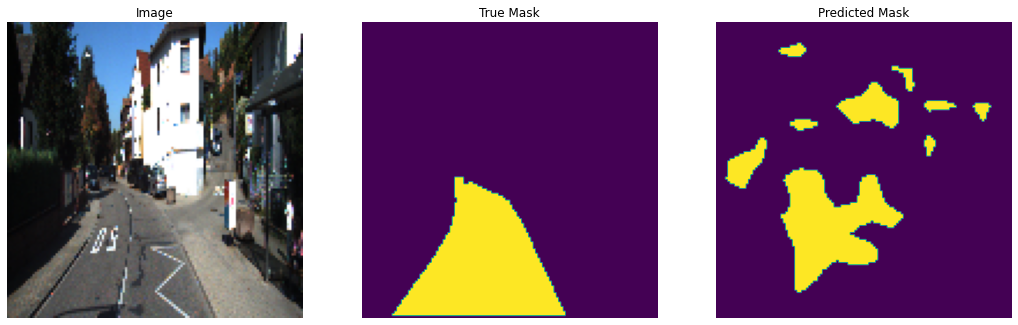

In [42]:
display_predictions(train_dl, 1)

# Training

In [43]:
class Metrics(object):
  def __init__(self):
    self.epochs = []
    self.losses = []
    self.metrics = []

  def __update_history(self, category: str, epoch_values: list) -> None:
    epoch_mean = sum(epoch_values)/len(epoch_values)
    if category == "loss":
      self.losses.append(epoch_mean)
    if category == "metric":
      self.metrics.append(epoch_mean)

  def update_loss(self, epoch_values: list) -> None:
    self.__update_history("loss", epoch_values)

  def update_metric(self, epoch_values: list) -> None:
    self.__update_history("metric", epoch_values)

  def update(self, n_epoch: int, epoch_losses: list, epoch_metrics: list) -> None:
    self.update_loss(epoch_losses)
    self.update_metric(epoch_metrics)
    self.epochs.append(n_epoch)

  def get_recent(self) -> tuple:
    return self.epochs[-1], self.losses[-1], self.metrics[-1]

TRAIN RESULTS:
      EPOCH: 0
      BCELoss: 1.435
      MeanIoU: 0.299

VALIDATION RESULTS: 
      EPOCH: 0
      BCELoss: 0.246
      MeanIoU: 0.289


TRAIN RESULTS:
      EPOCH: 50
      BCELoss: 0.041
      MeanIoU: 0.911

VALIDATION RESULTS: 
      EPOCH: 50
      BCELoss: 0.086
      MeanIoU: 0.836


TRAIN RESULTS:
      EPOCH: 100
      BCELoss: 0.021
      MeanIoU: 0.947

VALIDATION RESULTS: 
      EPOCH: 100
      BCELoss: 0.041
      MeanIoU: 0.918


TRAIN RESULTS:
      EPOCH: 150
      BCELoss: 0.019
      MeanIoU: 0.952

VALIDATION RESULTS: 
      EPOCH: 150
      BCELoss: 0.050
      MeanIoU: 0.915




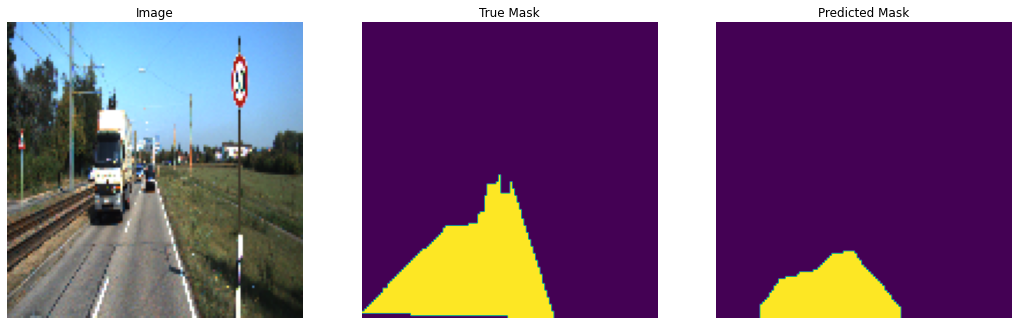

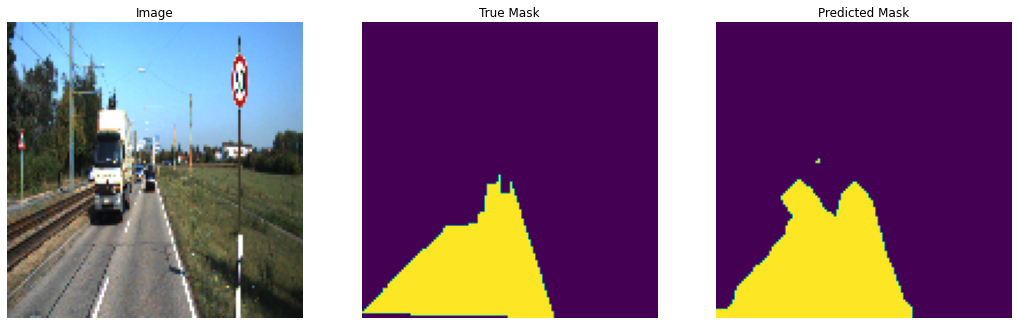

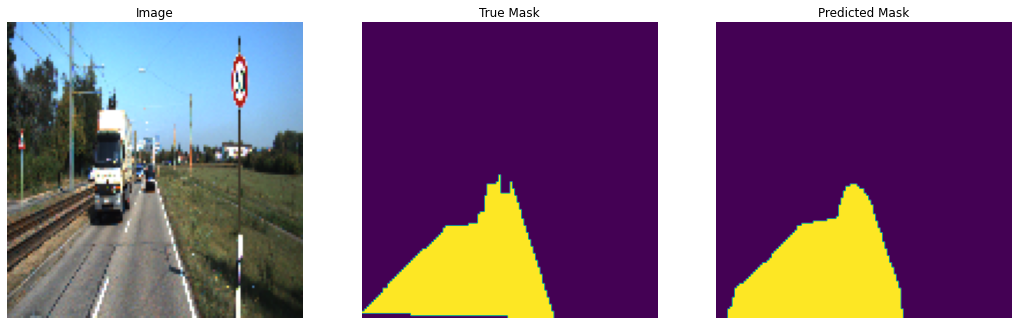

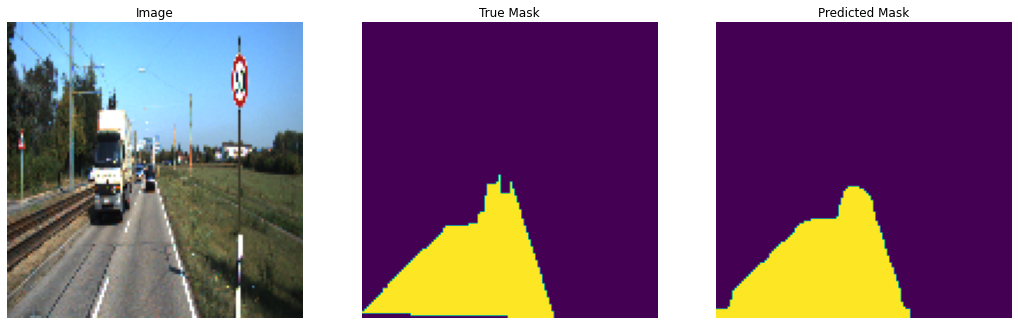

In [44]:
EPOCHS = 200
DISPLAY_FREQ = 50
train_metrics = Metrics()
val_metrics = Metrics()

for i in range(EPOCHS):
  # Train loop
  vgg16_fcn.train()
  train_bces = []
  train_ious = []
  for imgs, masks in train_dl:
    # zero gradients
    optim.zero_grad()

    # get logits
    logits = vgg16_fcn(imgs.to(device)).cpu()

    # compute loss
    loss = loss_fn(logits, masks.to(torch.float32))
    train_bces.append(loss.item())

    # compute gradients, update weights
    loss.backward()
    optim.step()

    # get mean IoU
    preds = get_pred_mask(logits)
    iou = mean_iou(preds, masks)
    train_ious.append(iou)
  
  # Update train history
  train_metrics.update(i, train_bces, train_ious)

  # Validation
  vgg16_fcn.eval()
  val_bces = []
  val_ious = []
  with torch.inference_mode():
    for imgs, masks in val_dl:
      # get logits
      logits = vgg16_fcn(imgs.to(device)).cpu()

      # compute loss
      loss = loss_fn(logits, masks.to(torch.float32))
      val_bces.append(loss.item())

      # get mean IoU
      preds = get_pred_mask(logits)
      iou = mean_iou(preds, masks)
      val_ious.append(iou)
    
    # Update validation history
    val_metrics.update(i, val_bces, val_ious)

  # Display results
  if (i % DISPLAY_FREQ) == 0:
    # Show predictions
    t_epoch, t_bce, t_iou = train_metrics.get_recent()
    v_epoch, v_bce, v_iou = val_metrics.get_recent()
    print(f"""TRAIN RESULTS:
      EPOCH: {t_epoch:0d}
      BCELoss: {t_bce:.3f}
      MeanIoU: {t_iou:.3f}""")
    print()

    print(f"""VALIDATION RESULTS: 
      EPOCH: {v_epoch:0d}
      BCELoss: {v_bce:.3f}
      MeanIoU: {v_iou:.3f}""")
    print()

    # show predictions
    display_predictions(val_dl, 1)
    print()

# Plot loss and metrics

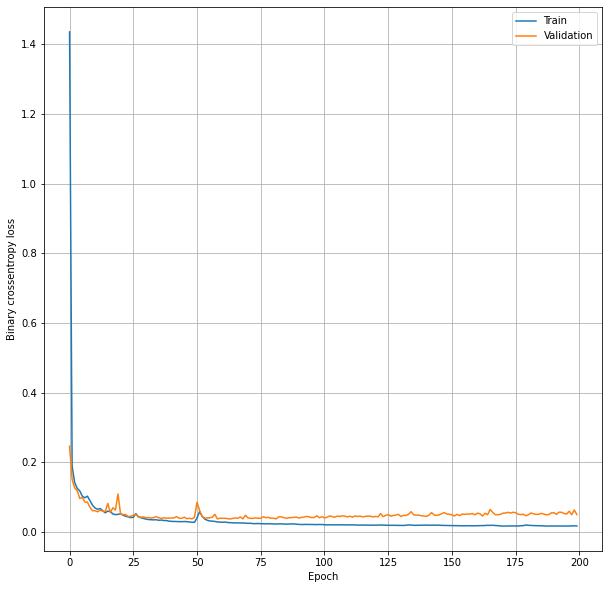

In [47]:
# BCE loss
plt.figure(figsize=(10,10))
plt.plot(train_metrics.epochs, train_metrics.losses)
plt.plot(val_metrics.epochs, val_metrics.losses)
plt.xlabel("Epoch")
plt.ylabel("Binary crossentropy loss")
plt.legend(["Train", "Validation"])
plt.grid()
plt.show()

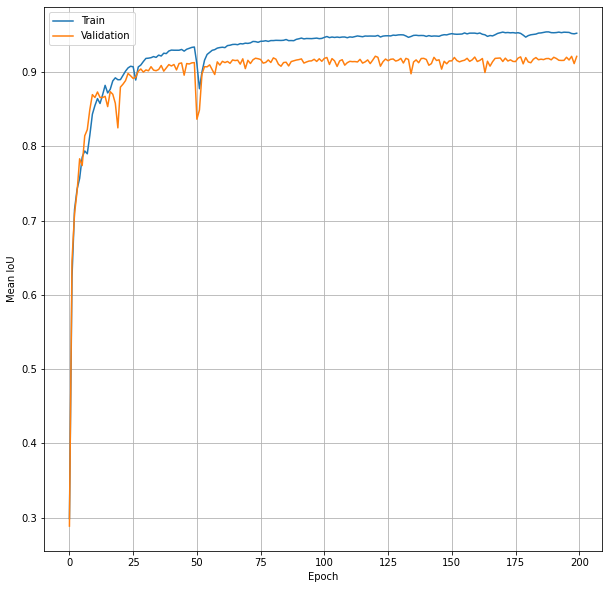

In [48]:
# Mean IoU
plt.figure(figsize=(10,10))
plt.plot(train_metrics.epochs, train_metrics.metrics)
plt.plot(val_metrics.epochs, val_metrics.metrics)
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.legend(["Train", "Validation"])
plt.grid()
plt.show()

# Evaluate on test set

In [99]:
# Super-impose mask on RGB image
def get_weighted_img(image: np.ndarray, mask: np.ndarray, alpha: float = 1.0,
                     beta: float = 0.5, gamma: float = 0.0) -> np.ndarray:
  return cv2.addWeighted(image, alpha, mask, beta, gamma)

def process_image_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
  # Convert mask to RGB image -> mask will be red channel
  mask = np.concatenate((mask, np.zeros_like(mask), np.zeros_like(mask)), axis=0)
  mask = np.asarray(mask, dtype=np.float32)

  # Convert mask to RGB image
  image = np.asarray(image, np.float32)

  # Get weighted image
  weighted_image = get_weighted_img(image, mask)

  return weighted_image

def plot_test_predictions(test_dl: DataLoader, n_imgs: int = 16):
  # Store images and masks
  plot_imgs = []
  plot_preds = []

  # Get mask predictions
  i = 0
  vgg16_fcn.eval()
  with torch.inference_mode():
    for imgs, masks in test_dl:
      preds = vgg16_fcn(imgs.to(device)).cpu()
      plot_imgs.append(imgs)
      plot_preds.append(preds)
      i += preds.shape[0]

      # break out once enough predictions received
      if i > n_imgs:
        break
  
  # Plot the predictions
  plot_imgs = torch.cat(plot_imgs, dim=0)[:n_imgs,]
  plot_preds = torch.cat(plot_preds, dim=0)[:n_imgs,]

  for img, pred in zip(plot_imgs, plot_preds):
    # Get weighted img
    weighted_img = torch.tensor(process_image_mask(img.numpy(), pred.numpy()),
                                dtype=torch.float32)

    # Plot real image and weighted image
    display_image(img, weighted_img, mask_title="Predicted Mask")

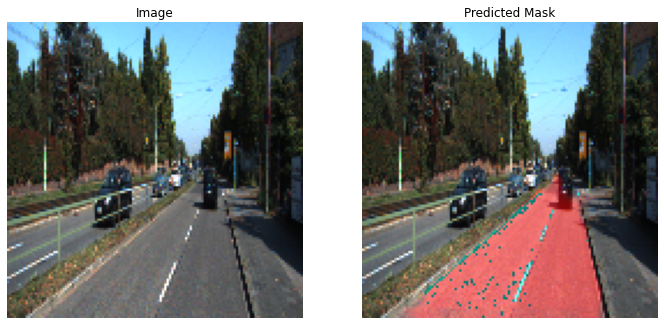

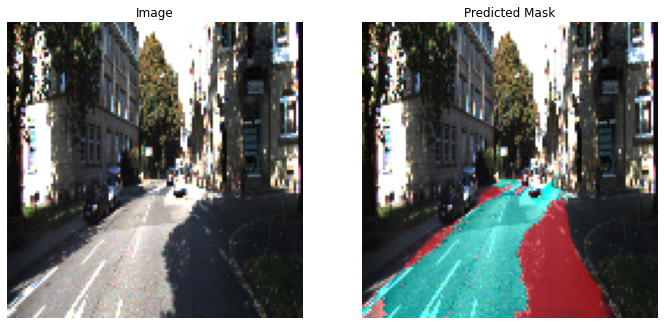

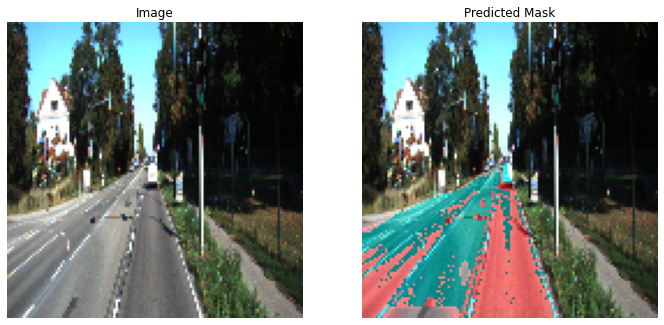

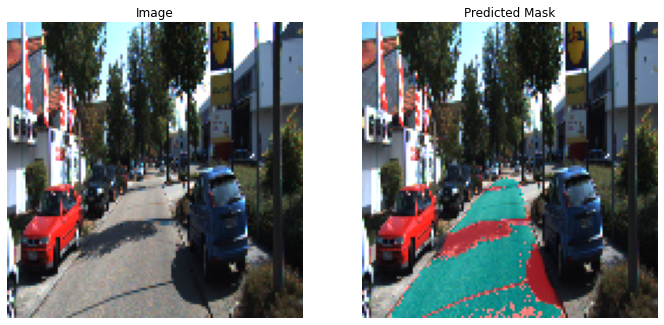

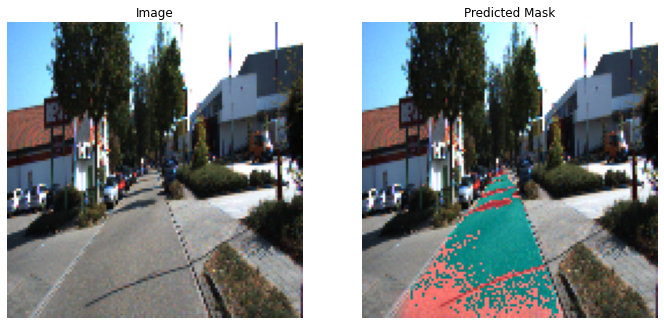

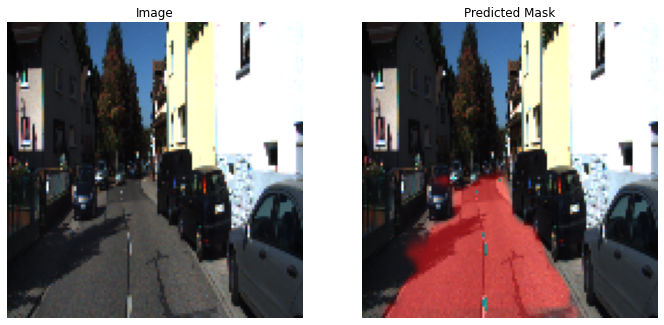

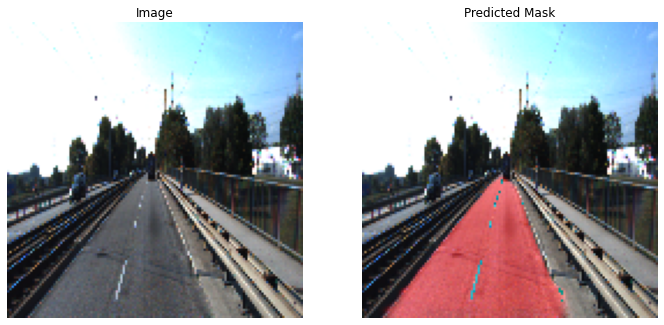

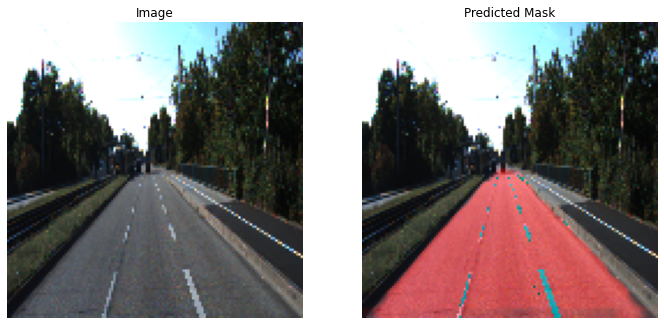

In [100]:
plot_test_predictions(test_dl, n_imgs=8)